In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random
import cv2
from tqdm import tqdm
import dgl
import networkx as nx

Using backend: pytorch


In [2]:
from torchvision.datasets import STL10
from torchvision import transforms
 
STL10_train = STL10("STL10", split='train', download=True, transform=transforms.ToTensor())
 
STL10_test = STL10("STL10", split='test', download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
def getpic(img,pos,k_size):#特徴点を中心に画像を抜き出す
    getimgs=[]
    pad_size=k_size//2
    #元画像をpad_size分パディング
    padimg=np.pad(img,pad_size)
    for i in range(len(pos)):
        #パディングした分座標をずらす
        x=int(pos[i].pt[0])+pad_size
        y=int(pos[i].pt[1])+pad_size
        #座標を中心にk_size分抜き出す
        getimg=padimg[x-k_size//2:x+k_size//2+1,y-k_size//2:y+k_size//2+1]
        getimgs.append(getimg)
    getimgs=torch.tensor(getimgs,dtype=torch.float32)

    return getimgs

In [19]:
#ノードが特徴記述子のトレーニングデータ作成


akaze=cv2.ORB_create()
graphs=[]
labels=[]
size=(512,512)
node_num=100
test_number=100444

for image,label in tqdm(STL10_train):
    #動作テスト
    #if test_number<0:
    #    break
    #else:
    #    test_number-=1

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        continue

    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=torch.tensor(des,dtype=torch.float32)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_des=torch.empty(node_num,des[0].shape[0],dtype=torch.float32)
        for i in range(1,node_num+1):
            top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/nnum{node_num}_ndatades_enone_orb.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 5000/5000 [02:21<00:00, 35.40it/s]


In [20]:
#ノードが特徴記述子のテストデータ作成
akaze=cv2.ORB_create()
graphs=[]
labels=[]
size=(512,512)
node_num=100
test_number=10044444
none_num=0
for image,label in tqdm(STL10_test):
    #動作テスト
    #if test_number<0:
    #    break
    #else:
    #    test_number-=1

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        none_num+=1
        continue


    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=torch.tensor(des,dtype=torch.float32)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_des=torch.empty(node_num,des[0].shape[0],dtype=torch.float32)
        for i in range(1,node_num+1):
            top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/test/nnum{node_num}_ndatades_enone_orb.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 8000/8000 [03:46<00:00, 35.35it/s]


In [6]:
#ノードが特徴点を中心とする画像のトレーニングデータ作成
akaze=cv2.AKAZE_create()
graphs=[]
labels=[]
size=(512,512)
node_num=20
k_size=9
test_number=100
test_mode=False

for image,label in tqdm(STL10_train):
    #動作テスト
    if test_mode==True:
        if test_number<0:
            break
        else:
            test_number-=1
    

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    #img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        continue

    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=getpic(img,kp,k_size)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_kp=[]
        for i in range(1,node_num+1):
            top_kp.append(kp[dec_sort_index[-i]])
        top_des=getpic(img,top_kp[:node_num],k_size)

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/nnum{node_num}_ndatapic{k_size}_enone_akaze.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 5000/5000 [01:30<00:00, 54.96it/s]


In [7]:
#ノードが特徴点を中心とする画像のテストデータ作成
akaze=cv2.AKAZE_create()
graphs=[]
labels=[]
size=(512,512)
node_num=20
k_size=9
test_number=100
test_mode=False

for image,label in tqdm(STL10_test):
    #動作テスト
    if test_mode==True:
        if test_number<0:
            break
        else:
            test_number-=1
    

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    #img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        continue

    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=getpic(img,kp,k_size)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_kp=[]
        for i in range(1,node_num+1):
            top_kp.append(kp[dec_sort_index[-i]])
        top_des=getpic(img,top_kp[:node_num],k_size)

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/test/nnum{node_num}_ndatapic{k_size}_enone_akaze.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

100%|██████████| 8000/8000 [02:16<00:00, 58.52it/s]


In [7]:
print(none_num)

2


# 以下雑多

In [52]:
def getpic(img,pos,k_size):#特徴点を中心に画像を抜き出す
    getimgs=[]
    pad_size=k_size//2
    #元画像をpad_size分パディング
    padimg=np.pad(img,pad_size)
    for i in range(len(pos)):
        #パディングした分座標をずらす
        x=int(pos[i].pt[0])+pad_size
        y=int(pos[i].pt[1])+pad_size
        #座標を中心にk_size分抜き出す
        getimg=padimg[x-k_size//2:x+k_size//2+1,y-k_size//2:y+k_size//2+1]
        getimgs.append(getimg)
    getimgs=torch.tensor(getimgs,dtype=torch.float32)

    return getimgs

In [39]:
akaze=cv2.AKAZE_create()
sift=cv2.SIFT_create()
orb=cv2.ORB_create()
times=[]
kps=np.zeros((3,len(STL10_train)))
dess=np.zeros((3,len(STL10_train)))

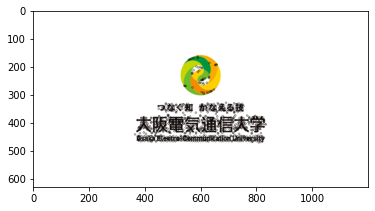

In [15]:
img=cv2.imread('../images/OECU_LOGO.png')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
kp,des=akaze.detectAndCompute(img,None)
kpimg=cv2.drawKeypoints(img,kp,None,4)
plt.imshow(kpimg)
plt.show()

In [8]:
print(img.shape)

(512, 512, 4)


In [27]:
c=0
skip=0
s=time.time()
for i,j in tqdm((STL10_train)):
    img=i.numpy().transpose(1,2,0)
    #img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp)==0:
        skip+=1
        continue
    else:    
        kps[0][c]=len(kp)
        dess[0][c]=len(des)
    c+=1
times.append(time.time() - s)


100%|██████████| 5000/5000 [00:05<00:00, 975.99it/s] 


In [39]:
print(times,len(kps[0]),skip,np.average(kps[0][:139]),np.std(kps[0][:139]),np.max(kps[0][:139]),np.min(kps[0][:139]),np.median(kps[0][:139]))
print(kps[0][4])

[5.124981164932251] 5000 139 9.323741007194245 5.4524970549612926 25.0 1.0 9.0
10.0


In [33]:
oo=[i for i in range(10)]

In [35]:
print(oo)
print(oo[:5])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4]


In [16]:
c=0
s=time.time()
for i,j in tqdm((STL10_train)):
    img=i.numpy().transpose(1,2,0)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=sift.detectAndCompute(img,None)
    kps[1][c]=len(kp)
    dess[1][c]=len(des)
    c+=1
times.append(time.time() - s)


100%|██████████| 5000/5000 [01:58<00:00, 42.28it/s]


In [17]:
c=0
s=time.time()
for i,j in tqdm((STL10_train)):
    img=i.numpy().transpose(1,2,0)
    img=cv2.resize(img,(512,512),interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=orb.detectAndCompute(img,None)
    kps[2][c]=len(kp)
    dess[2][c]=len(des)
    c+=1
times.append(time.time() - s)

print(times)

100%|██████████| 5000/5000 [00:18<00:00, 267.67it/s]

[94.58219456672668, 118.27110433578491, 18.681317806243896]


In [24]:
for i in range(3):
    print(np.average(kps[i]),np.std(kps[i]),np.max(kps[i]),np.min(kps[i]),np.median(kps[i]))

497.6868 277.89436681185174 2069.0 4.0 454.0
457.118 290.3243904256065 2176.0 25.0 387.0
419.4008 87.4143681516946 500.0 21.0 446.0


In [26]:
np.save('dess',dess)

In [13]:
for img,label in tqdm(STL10_train):
    img=img.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=orb.detectAndCompute(img,None)
    break

  0%|          | 0/5000 [00:00<?, ?it/s]


In [18]:
print(des[0].shape[0])

32


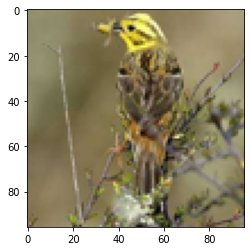

In [43]:
img=STL10_train[0][0]
img = img.permute(1,2,0).numpy()
plt.imshow(img)
plt.show()

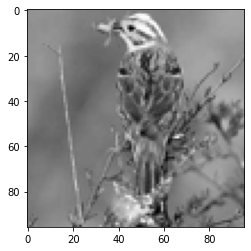

In [44]:
gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(gray,cmap='gray')
plt.show()

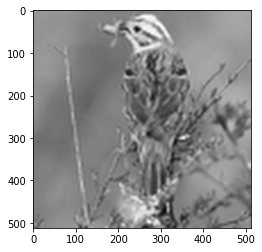

In [45]:
up = cv2.resize(gray,(512,512),interpolation=cv2.INTER_LANCZOS4)
plt.imshow(up,cmap='gray')
plt.show()

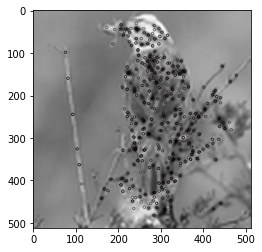

In [46]:
up=cv2.normalize(up,None,0,255,cv2.NORM_MINMAX).astype('uint8')
kp,des=akaze.detectAndCompute(up,None)
kpimg=cv2.drawKeypoints(up,kp,None,4)
plt.imshow(kpimg,cmap='gray')
plt.show()

In [47]:
node_num=20
dec=np.empty([len(kp)])
for i in range(len(kp)):
    dec[i]=kp[i].response
dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
    top_des=torch.tensor(des,dtype=torch.float32)
    g=nx.complete_graph(len(des))
    G=dgl.from_networkx(g)
    #ノード特徴代入
    G.ndata['feat']=top_des
else:#kpの数がnode_num以上であればこちら
    #強度が大きい順にノード数分のdesを格納
    top_des=torch.empty(node_num,61,dtype=torch.float32)
    top_kp=[]
    for i in range(1,node_num+1):
        top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()
        top_kp.append(kp[dec_sort_index[-i]])

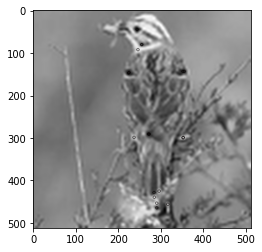

In [48]:
top_kpimg=cv2.drawKeypoints(up,top_kp,None,4)
plt.imshow(top_kpimg,cmap='gray')
plt.show()

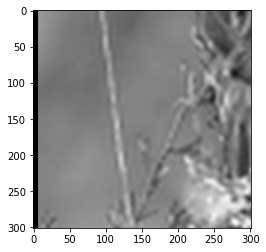

In [49]:
minipic=getpic(up,top_kp[13].pt,300)
plt.imshow(minipic,cmap='gray')
plt.show()

In [51]:
print(type(minipic))

<class 'numpy.ndarray'>


In [53]:
#node featureが特徴点を中心とする画像
akaze=cv2.AKAZE_create()
graphs=[]
labels=[]
size=(512,512)
node_num=20
k_size=10
test_number=10
test_mode=True

for image,label in tqdm(STL10_train):
    #動作テスト
    if test_mode==True:
        if test_number<0:
            break
        else:
            test_number-=1
    

    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    #img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp) == 0:
        continue

    #上位抜出し
    dec=np.empty([len(kp)])
    for i in range(len(kp)):
        dec[i]=kp[i].response
    dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


    if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
        top_des=getpic(img,top_kp,k_size)
        g=nx.complete_graph(len(des))
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des
    else:#kpの数がnode_num以上であればこちら
        #強度が大きい順にノード数分のdesを格納
        top_des=getpic(img,top_kp[:node_num],k_size)

        #グラフ作成 networkx -- dgl経由
        g=nx.complete_graph(node_num)
        G=dgl.from_networkx(g)
        #ノード特徴代入
        G.ndata['feat']=top_des

    #graphs代入　labels代入
    graphs.append(G)
    labels.append(label)

#グラフの保存
output_labels={'label':torch.tensor(labels)}
path=f'../data/STL10 Datasets/train/nnum{node_num}_ndatapic_enone_akaze.dgl'
dgl.save_graphs(path,g_list=graphs,labels=output_labels)
    

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_4264/1995976418.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  getimgs=torch.tensor(getimgs,dtype=torch.float32)
  0%|          | 11/5000 [00:00<02:18, 35.95it/s]


In [56]:
graphs[1].ndata['feat'].shape

torch.Size([20, 11, 11])

In [41]:
ok=[0,0,0]
bad=[0,0,0]
for image,label in tqdm(STL10_test):
    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    #img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=akaze.detectAndCompute(img,None)
    if len(kp)==0:
        bad[0]+=1
    else:
        ok[0]+=1

for image,label in tqdm(STL10_test):
    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=orb.detectAndCompute(img,None)
    if len(kp)==0:
        bad[1]+=1
    else:
        ok[1]+=1
for image,label in tqdm(STL10_test):
    #画像拡大　特徴抽出
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #アルゴリズムがORBかSIFTの場合下一行を実行
    img=cv2.normalize(img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
    kp,des=sift.detectAndCompute(img,None)
    if len(kp)==0:
        bad[2]+=1
    else:
        ok[2]+=1

print(f'akaze:total(5000),ok({ok[0]}),bad({bad[0]})')
print(f'orb:total(5000),ok({ok[1]}),bad({bad[1]})')
print(f'sift:total(5000),ok({ok[2]}),bad({bad[2]})')

100%|██████████| 8000/8000 [03:23<00:00, 39.37it/s]

akaze:total(5000),ok(7998),bad(2)
orb:total(5000),ok(8000),bad(0)
sift:total(5000),ok(8000),bad(0)


In [30]:
start=time.time()
for i in range(20):
    getpic(up,top_kp[i].pt,120)
print(time.time()-start)

0.0014040470123291016


In [29]:
G=nx.complete_graph(node_num)
pos={}
for n,i in enumerate(top_kp):
    pos[n]=i.pt

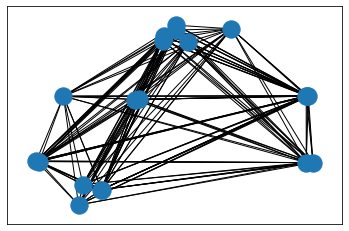

In [30]:
nx.draw_networkx(G,pos=pos,with_labels=False)
plt.show()

In [31]:
print(des[0])

[  3 230 133   1 176 102  71  63 224 111  48 244 235 126 113 128   0  34
 130   0   0   4 179 191 104  64 252 107  26  51 192 255  31   0 160 255
 255 255 127   0 254 255 255   3 240 192 224  47  96   0   0 249 143  63
 255 255 255  25 134   0   3]


In [8]:
cars=[]
for i,j in STL10_train:
    if j==2:
        cars.append(i)

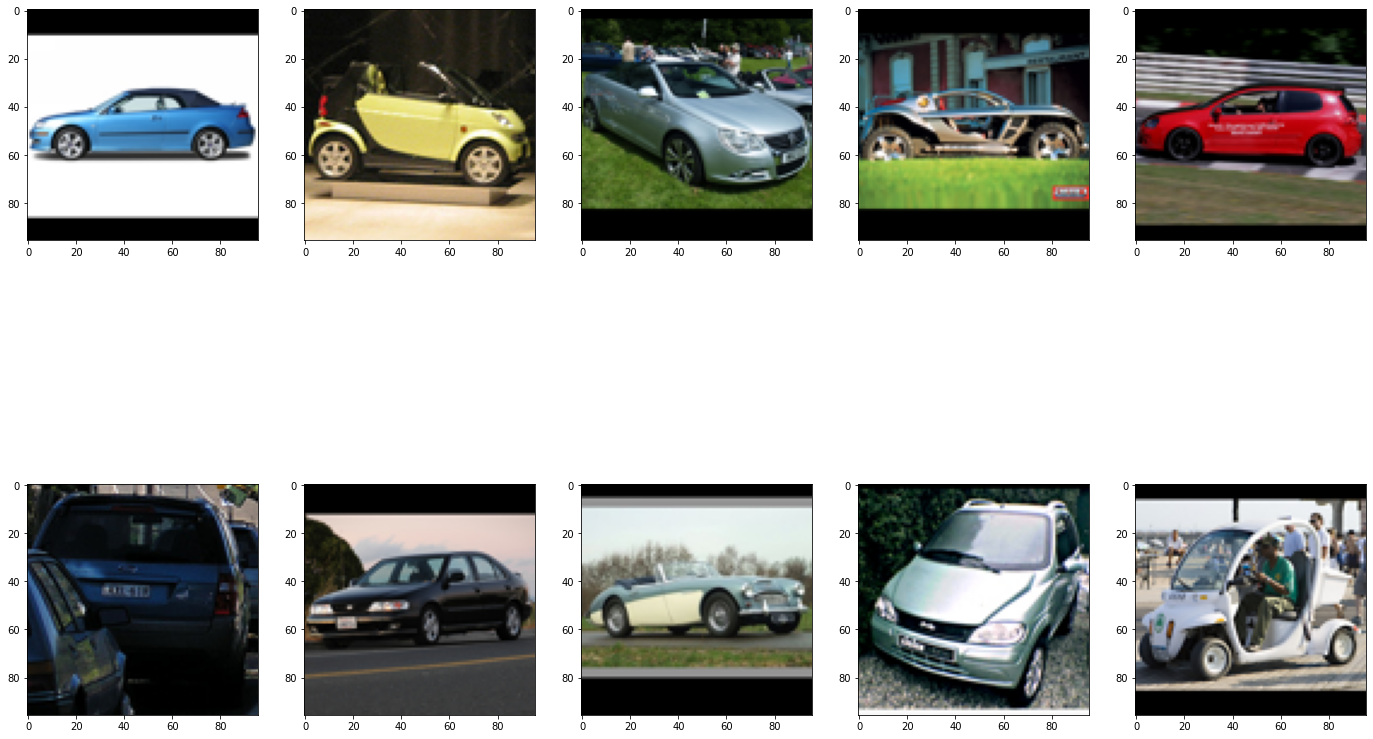

In [45]:
plt.figure(figsize=(12*2,8*2))
for i,img in enumerate(cars[30:]):
    plt.subplot(2,5,i+1)
    img=img.permute(1,2,0)
    plt.imshow(img)
    if i==6:
        true_img=img.numpy()
    if i == 9:
        break
plt.show()

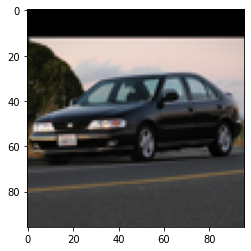

In [42]:
plt.imshow(true_img)
plt.show()

In [46]:

true_img=cv2.normalize(true_img,None,0,255,cv2.NORM_MINMAX).astype('uint8')
print(true_img)

[[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[60 60 61]
  [60 60 60]
  [59 59 59]
  ...
  [64 64 65]
  [61 62 62]
  [61 61 63]]

 [[61 61 61]
  [60 60 60]
  [62 62 62]
  ...
  [57 57 59]
  [55 54 55]
  [56 55 56]]

 [[61 61 61]
  [58 58 58]
  [58 58 58]
  ...
  [59 59 59]
  [54 54 54]
  [56 56 56]]]


In [70]:
grayimg=cv2.cvtColor(true_img,cv2.COLOR_BGR2GRAY)
true_img=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
cv2.imwrite('car.jpg',true_img)

True

In [65]:
img=cv2.imread('car.jpg')
size=(512,512)
akaze=cv2.AKAZE_create()
grayimg=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
upimg=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
kp,des=akaze.detectAndCompute(upimg,None)


In [66]:

node_num=10
dec=np.empty([len(kp)])
for i in range(len(kp)):
    dec[i]=kp[i].response
dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
    top_des=torch.tensor(des,dtype=torch.float32)
    g=nx.complete_graph(len(des))
    G=dgl.from_networkx(g)
    #ノード特徴代入
    G.ndata['feat']=top_des
else:#kpの数がnode_num以上であればこちら
    #強度が大きい順にノード数分のdesを格納
    top_des=torch.empty(node_num,61,dtype=torch.float32)
    top_kp=[]
    for i in range(1,node_num+1):
        top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()
        top_kp.append(kp[dec_sort_index[-i]])

In [34]:
print(img.dtype)

uint8


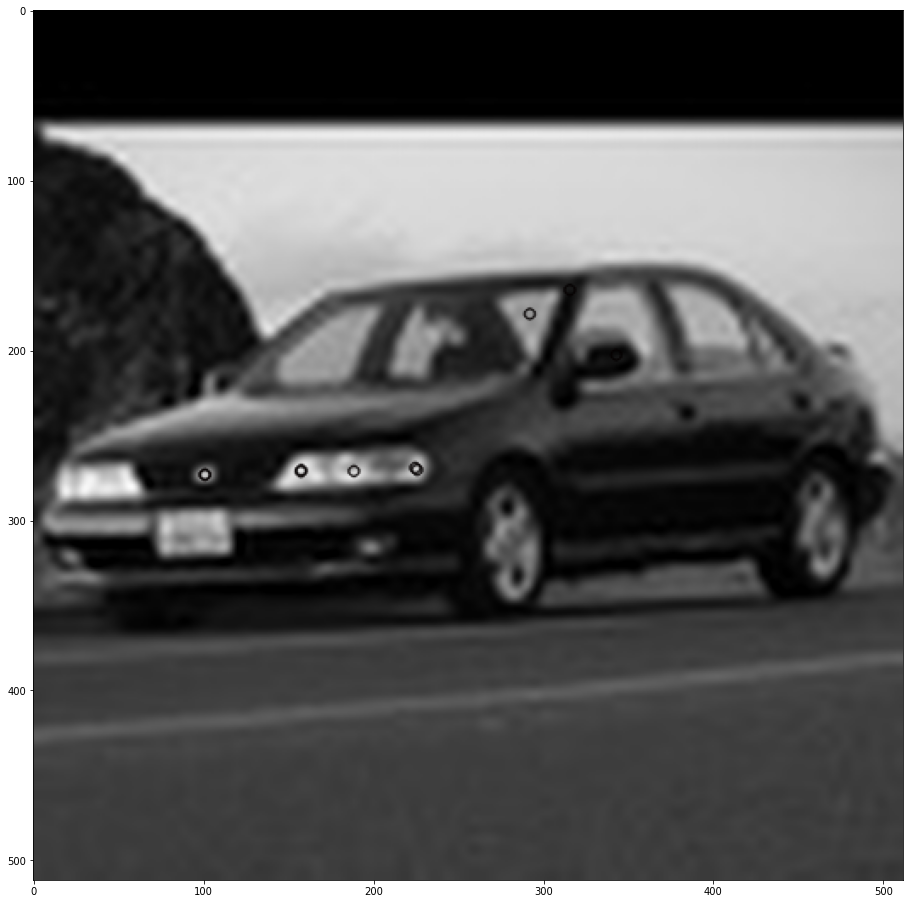

In [67]:
kpimg=cv2.drawKeypoints(upimg,top_kp,None,4)
plt.figure(figsize=(12*2,8*2))
plt.imshow(kpimg)
plt.show()

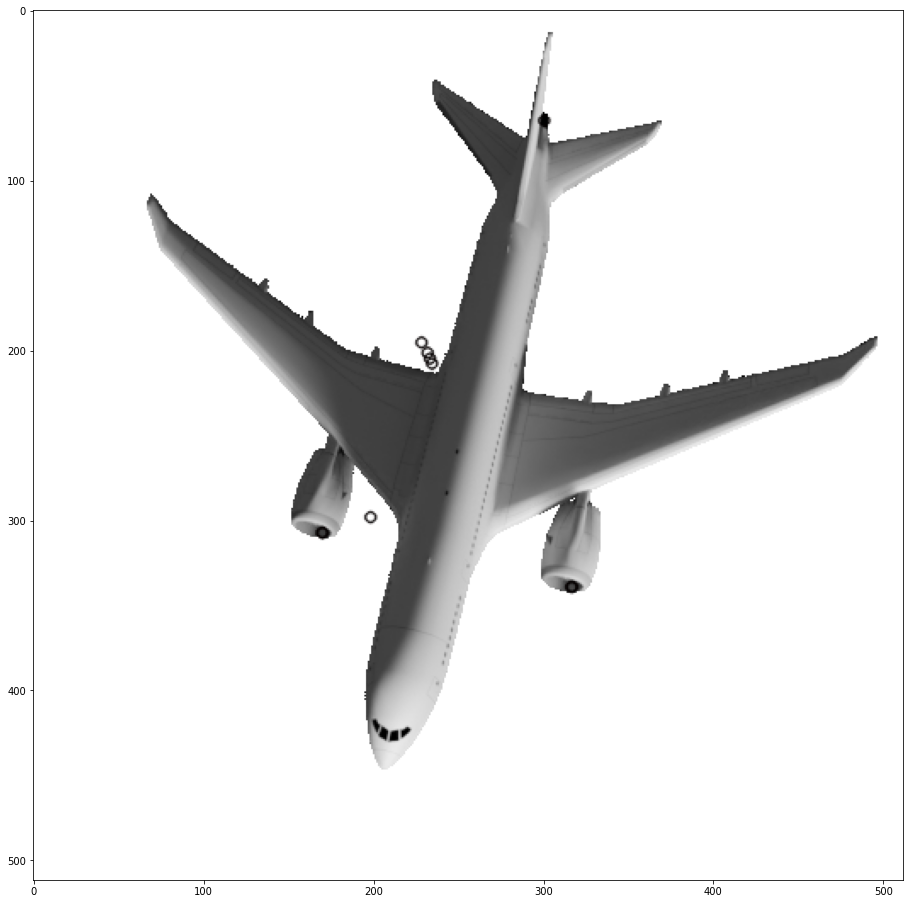

In [62]:
img=cv2.imread('../images/r_002.png',-1)
index=np.where(img[:,:,3]==0)
img[index]=[255,255,255,255]

size=(512,512)
akaze=cv2.AKAZE_create()
grayimg=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
upimg=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
kp,des=akaze.detectAndCompute(upimg,None)

node_num=10
dec=np.empty([len(kp)])
for i in range(len(kp)):
    dec[i]=kp[i].response
dec_sort_index=np.argsort(dec) #大きい順のインデックスを格納した配列


if len(kp)<node_num: #もしkpの数がnode_num以下だった場合ノード数len(kp)個のグラフを作成
    top_des=torch.tensor(des,dtype=torch.float32)
    g=nx.complete_graph(len(des))
    G=dgl.from_networkx(g)
    #ノード特徴代入
    G.ndata['feat']=top_des
else:#kpの数がnode_num以上であればこちら
    #強度が大きい順にノード数分のdesを格納
    top_des=torch.empty(node_num,61,dtype=torch.float32)
    top_kp=[]
    for i in range(1,node_num+1):
        top_des[i-1]=torch.from_numpy(des[dec_sort_index[-i]]).clone()
        top_kp.append(kp[dec_sort_index[-i]])

kpimg=cv2.drawKeypoints(upimg,top_kp,None,4)
plt.figure(figsize=(12*2,8*2))
plt.imshow(kpimg)
plt.show()

<class 'numpy.ndarray'>
21 637


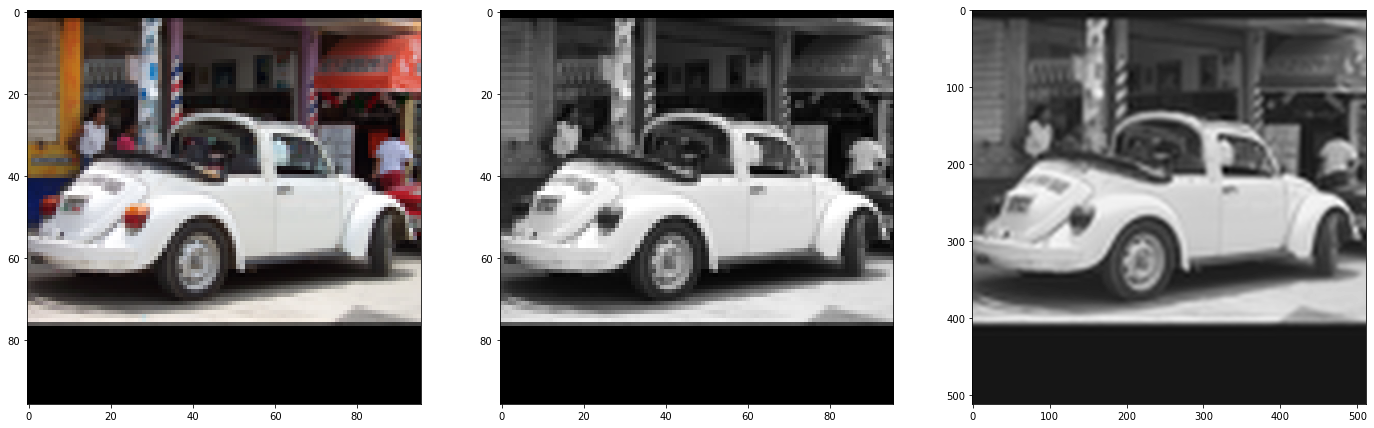

In [22]:
print(type(img))
plt.figure(figsize=(12*2,8*2))
akaze=cv2.AKAZE_create()
size=(512,512)

grayimg=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
upimg=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
kp,des=akaze.detectAndCompute(grayimg,None)
upkp,updes=akaze.detectAndCompute(upimg,None)
print(len(kp),len(upkp))

plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(grayimg,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(upimg,cmap='gray')

plt.show()

In [38]:
clss=[[],[],[],[],[],[],[],[],[],[]]
for image,label in tqdm(STL10_train):
    img=image.numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=akaze.detectAndCompute(img,None)
    clss[label].append(len(kp))

    

100%|██████████| 5000/5000 [01:11<00:00, 69.58it/s]


In [49]:
kpnum=np.zeros(max(clss[0])+1)

In [53]:
kpnum.shape[0]

1834

In [50]:
for i in clss[0]:
    kpnum[i] +=1

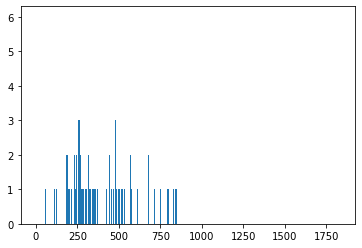

In [55]:
x=[i for i in range(kpnum.shape[0])]
plt.bar(x,kpnum)
plt.show()

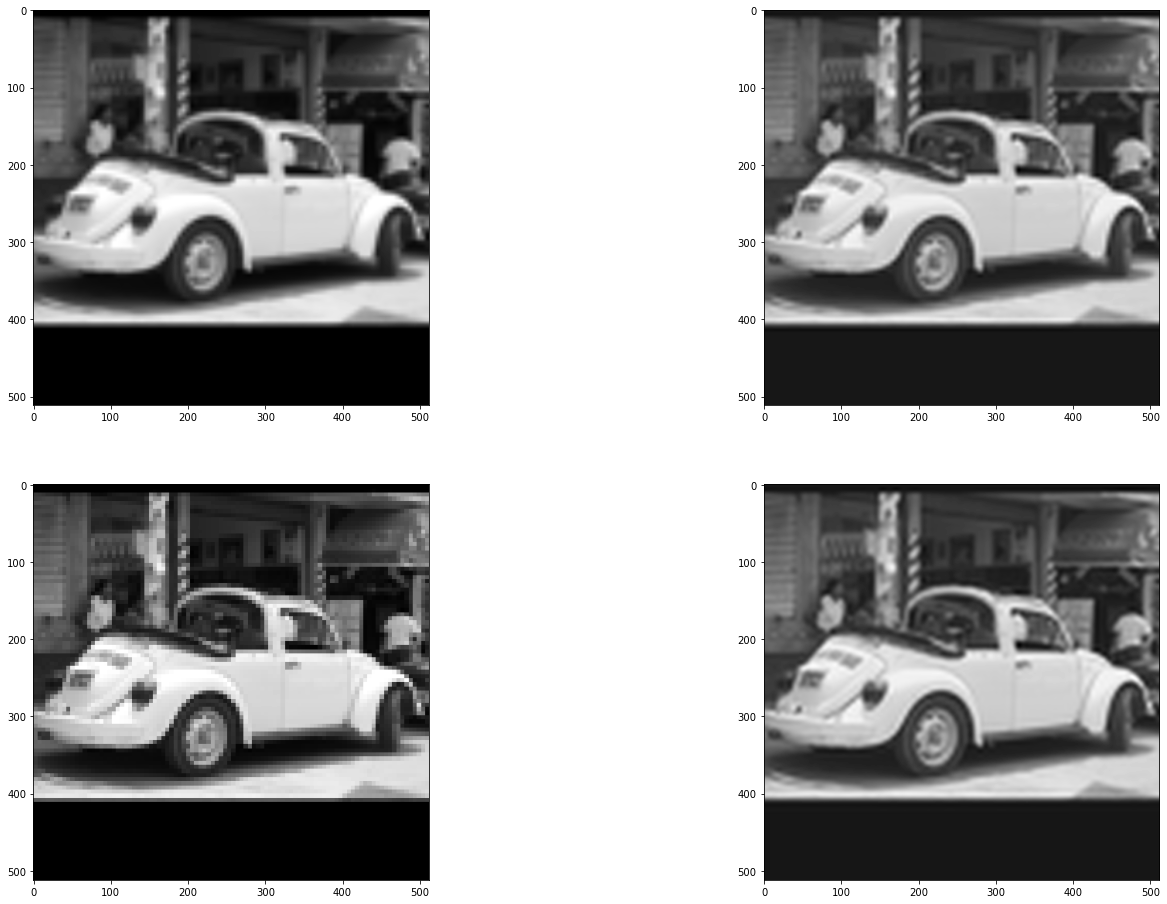

In [26]:
plt.figure(figsize=(12*2,8*2))

upimgs=[]
linear=cv2.resize(grayimg,size,interpolation=cv2.INTER_LINEAR)
upimgs.append(linear)
cubic=cv2.resize(grayimg,size,interpolation=cv2.INTER_CUBIC)
upimgs.append(cubic)
nearest=cv2.resize(grayimg,size,interpolation=cv2.INTER_NEAREST)
upimgs.append(nearest)
lanczos4=cv2.resize(grayimg,size,interpolation=cv2.INTER_LANCZOS4)
upimgs.append(lanczos4)


for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(upimgs[i],cmap='gray')
plt.show()


In [38]:
akaze=cv2.AKAZE_create()
kps=[]
start=time.time()
for i in range(3):
    kp=akaze.detect(STL10_train[i][0].numpy().transpose(1,2,0))
print(time.time()-start)

0.003793478012084961


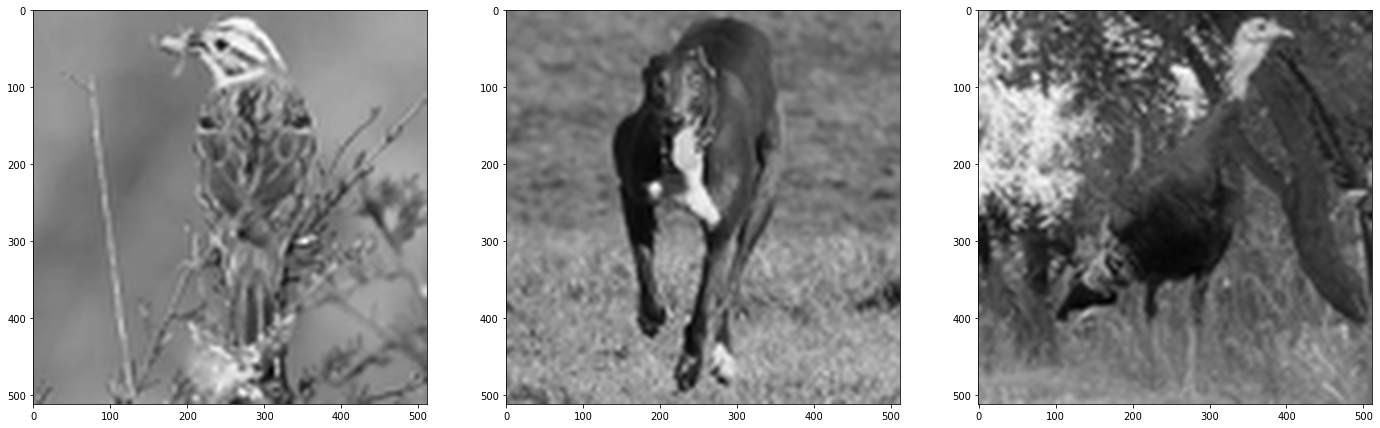

In [57]:
kps=[]
size=(512,512)
plt.figure(figsize=(12*2,8*2))
for i in range(3):
    img=STL10_train[i][0].numpy().transpose(1,2,0)
    img=cv2.resize(img,size,interpolation=cv2.INTER_LANCZOS4)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    plt.subplot(1,3,i+1)
    plt.imshow(img,cmap='gray')
    kps.append(akaze.detectAndCompute(img,None)[0])
plt.show()

In [52]:
print(len(kps[2]))

337


In [38]:
g5=nx.complete_graph(5)
print(g5)
g5.add_nodes_from([(1,{'feat':[1,2,32,3,4,5,3452345,43,5,45,23]})])
g5.add_nodes_from([(2,{'feat':200})])
print(nx.get_node_attributes(g5,'feat'))

Graph with 5 nodes and 10 edges
{1: [1, 2, 32, 3, 4, 5, 3452345, 43, 5, 45, 23], 2: 200}


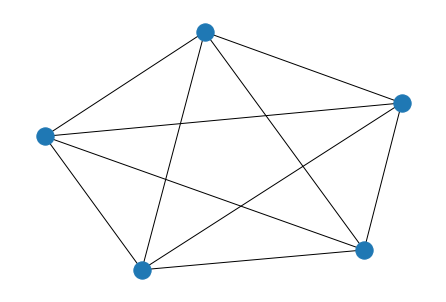

In [25]:
nx.draw(g5)
plt.show()

In [26]:
dglg5=dgl.from_networkx(g5)

In [27]:
print(dglg5)

Graph(num_nodes=5, num_edges=20,
      ndata_schemes={}
      edata_schemes={})
